<a href="https://colab.research.google.com/github/iProlly/Comchem/blob/main/Oil_ML_Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from google.colab import drive
from random import randrange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import io

In [2]:
def augment_data_all(X, num_new_samples, noise_std=0.05):
    n_samples = len(X)
    X_augmented = []

    for _ in range(num_new_samples):
        # Generate random coefficients for all samples
        coefficients = np.random.rand(n_samples)

        # Normalize coefficients to sum to 1
        coefficients /= np.sum(coefficients)

        # Create the new sample as a weighted sum of all samples
        new_sample = np.sum(coefficients[:, np.newaxis] * X, axis=0)

        noise = np.random.normal(0, noise_std * (new_sample.max() - new_sample.min()), new_sample.shape)
        new_sample += noise

        # Renormalize to range [0, 10000]
        new_sample = 10000 * (new_sample - new_sample.min()) / (new_sample.max() - new_sample.min())

        X_augmented.append(new_sample)

    return X_augmented

In [3]:
raw = pd.read_csv('/content/IR Combine.csv')

testing_number = 400
testing_data = []
testing_labels = []
data = []
labels = []

labels_raw = raw.iloc[:, 0].values
data_raw = raw.iloc[:, 1:].values

In [4]:
for i in range(np.unique(labels_raw).shape[0]):
  data_temp = []
  labels_temp = []
  for j in range(labels_raw.shape[0]):
    if np.unique(labels_raw)[i] == labels_raw[j]:
      data_temp.append(data_raw[j])
      labels_temp.append(labels_raw[j])

  data_augmented = augment_data_all(data_temp, 292)
  data_temp.extend(data_augmented)
  labels_temp.extend(labels_temp[:1]*len(data_augmented))
  data.extend(data_temp)
  labels.extend(labels_temp)

data = np.array(data)
labels = np.array(labels)

for k in range(testing_number):
  random_index = randrange(len(data))
  testing_labels.append(labels[random_index])
  testing_data.append(data[random_index])
  data = np.delete(data, random_index, 0)
  labels = np.delete(labels, random_index, 0)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_train = X_train[..., np.newaxis]  # Add channel dimension for CNN
X_test = X_test[..., np.newaxis]
testing_data = testing_data[..., np.newaxis]

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.2486 - loss: 7158.2915 - val_accuracy: 0.9783 - val_loss: 0.0919
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9830 - loss: 0.0741 - val_accuracy: 0.9867 - val_loss: 0.0482
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.9868 - loss: 0.0984 - val_accuracy: 0.9883 - val_loss: 0.0460
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9888 - loss: 0.0465 - val_accuracy: 0.9883 - val_loss: 0.0420
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9927 - loss: 0.0456 - val_accuracy: 0.9883 - val_loss: 0.0378
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9940 - loss: 0.0331 - val_accuracy: 0.9967 - val_loss: 0.0309
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9987 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0255
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9987 - loss: 0.0241 - val_accu

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0196
Test accuracy: 100.00%


In [10]:
prediction = model.predict(testing_data)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction, axis=1)

# Decode the prediction to get the class label
predicted_class = label_encoder.inverse_transform(predicted_class_index)

point = 0
for i in range(len(predicted_class)):
  if predicted_class[i] == testing_labels[i]:
    point+=1
print("Percentage accuracy:", point/len(predicted_class)*100)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Percentage accuracy: 100.0


Confusion Matrix in Table Format:
                   Benzaldehyde  Carvone  Cinnamaldehyde  Ethyl Benzoate  \
Benzaldehyde                 50        0               0               0   
Carvone                       0       43               0               0   
Cinnamaldehyde                0        0              49               0   
Ethyl Benzoate                0        0               0              52   
Eugenol                       0        0               0               0   
Limonene                      0        0               0               0   
Methyl Salicylate             0        0               0               0   
Trans-anethole                0        0               0               0   

                   Eugenol  Limonene  Methyl Salicylate  Trans-anethole   
Benzaldehyde             0         0                  0                0  
Carvone                  0         0                  0                0  
Cinnamaldehyde           0         0                  0 

<Figure size 800x600 with 0 Axes>

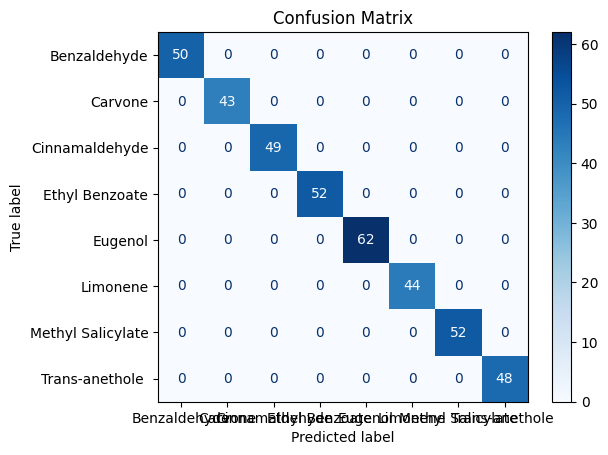

In [11]:
conf_matrix = confusion_matrix(testing_labels, predicted_class, labels = np.unique(labels))

# Optional: Display the confusion matrix as a formatted table
# Convert integer labels back to original string labels
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=label_encoder.classes_,  # Rows (True Labels)
    columns=label_encoder.classes_  # Columns (Predicted Labels)
)

# Display the confusion matrix
print("Confusion Matrix in Table Format:")
print(conf_matrix_df)

# Step 5: Visualize the Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()